In [1]:
region_map = {
    # Europe
    "Finland": "Europe",
    "Denmark": "Europe",
    "Iceland": "Europe",
    "Sweden": "Europe",
    "Netherlands": "Europe",
    "Norway": "Europe",
    "Luxembourg": "Europe",
    "Switzerland": "Europe",
    "Belgium": "Europe",
    "Ireland": "Europe",
    "Lithuania": "Europe",
    "Austria": "Europe",
    "Slovenia": "Europe",
    "Czechia": "Europe",
    "Germany": "Europe",
    "United Kingdom": "Europe",
    "Poland": "Europe",
    "France": "Europe",
    "Romania": "Europe",
    "Spain": "Europe",
    "Estonia": "Europe",
    "Italy": "Europe",
    "Latvia": "Europe",
    "Slovakia": "Europe",
    "Portugal": "Europe",
    "Hungary": "Europe",
    "Montenegro": "Europe",
    "Croatia": "Europe",
    "Greece": "Europe",
    "Bulgaria": "Europe",
    "North Macedonia": "Europe",
    "Albania": "Europe",
    "Serbia": "Europe",
    "Bosnia and Herzegovina": "Europe",
    "Ukraine": "Europe",
    "Kosovo": "Europe",
    
    # North America
    "United States": "North America",
    "Canada": "North America",
    "Mexico": "North America",
    "Belize": "North America",
    
    # Central & South America
    "Costa Rica": "Latin America",
    "Brazil": "Latin America",
    "El Salvador": "Latin America",
    "Panama": "Latin America",
    "Argentina": "Latin America",
    "Guatemala": "Latin America",
    "Chile": "Latin America",
    "Nicaragua": "Latin America",
    "Paraguay": "Latin America",
    "Uruguay": "Latin America",
    "Ecuador": "Latin America",
    "Honduras": "Latin America",
    "Colombia": "Latin America",
    "Peru": "Latin America",
    "Bolivia": "Latin America",
    "Dominican Republic": "Latin America",
    "Venezuela": "Latin America",
    "Jamaica": "Latin America",
    "Trinidad and Tobago": "Latin America",
    "Haiti": "Latin America",  # if present
    
    # Asia-Pacific
    "Australia": "Oceania",
    "New Zealand": "Oceania",
    "Israel": "Middle East",
    "United Arab Emirates": "Middle East",
    "Saudi Arabia": "Middle East",
    "Kuwait": "Middle East",
    "Bahrain": "Middle East",
    "Oman": "Middle East",
    "Qatar": "Middle East",  # if present
    "Turkey": "Middle East",
    "State of Palestine": "Middle East",
    "Iran": "Middle East",
    "Iraq": "Middle East",
    "Jordan": "Middle East",
    "Lebanon": "Middle East",
    
    # Asia
    "China": "Asia",
    "India": "Asia",
    "Pakistan": "Asia",
    "Bangladesh": "Asia",
    "Nepal": "Asia",
    "Sri Lanka": "Asia",
    "Myanmar": "Asia",
    "Thailand": "Asia",
    "Vietnam": "Asia",
    "Cambodia": "Asia",
    "Lao PDR": "Asia",
    "Indonesia": "Asia",
    "Malaysia": "Asia",
    "Singapore": "Asia",
    "Philippines": "Asia",
    "Japan": "Asia",
    "Republic of Korea": "Asia",
    "Taiwan Province of China": "Asia",
    "Mongolia": "Asia",
    "Kazakhstan": "Asia",
    "Uzbekistan": "Asia",
    "Kyrgyzstan": "Asia",
    "Tajikistan": "Asia",
    "Armenia": "Asia",
    "Azerbaijan": "Asia",
    "Georgia": "Asia",
    "Hong Kong SAR of China": "Asia",
    "Maldives": "Asia",  # if present
    
    # Africa
    "South Africa": "Africa",
    "Nigeria": "Africa",
    "Ghana": "Africa",
    "Kenya": "Africa",
    "Uganda": "Africa",
    "Tanzania": "Africa",
    "Ethiopia": "Africa",
    "Zimbabwe": "Africa",
    "Zambia": "Africa",
    "Malawi": "Africa",
    "Mozambique": "Africa",
    "Cameroon": "Africa",
    "Senegal": "Africa",
    "Namibia": "Africa",
    "Côte d’Ivoire": "Africa",
    "Guinea": "Africa",
    "Chad": "Africa",
    "Mali": "Africa",
    "Somalia": "Africa",
    "Mauritania": "Africa",
    "Burkina Faso": "Africa",
    "Benin": "Africa",
    "Liberia": "Africa",
    "Sierra Leone": "Africa",
    "Madagascar": "Africa",
    "Gabon": "Africa",
    "Congo": "Africa",
    "DR Congo": "Africa",
    "Botswana": "Africa",
    "Eswatini": "Africa",
    "Lesotho": "Africa",
    "Comoros": "Africa",
    "Mauritius": "Africa",
    "Libya": "Africa",
    "Egypt": "Africa",
    "Algeria": "Africa",
    "Tunisia": "Africa",
    "Morocco": "Africa",
    "Sudan": "Africa",   # if present
    "Yemen": "Middle East/Africa"  # sometimes grouped
}


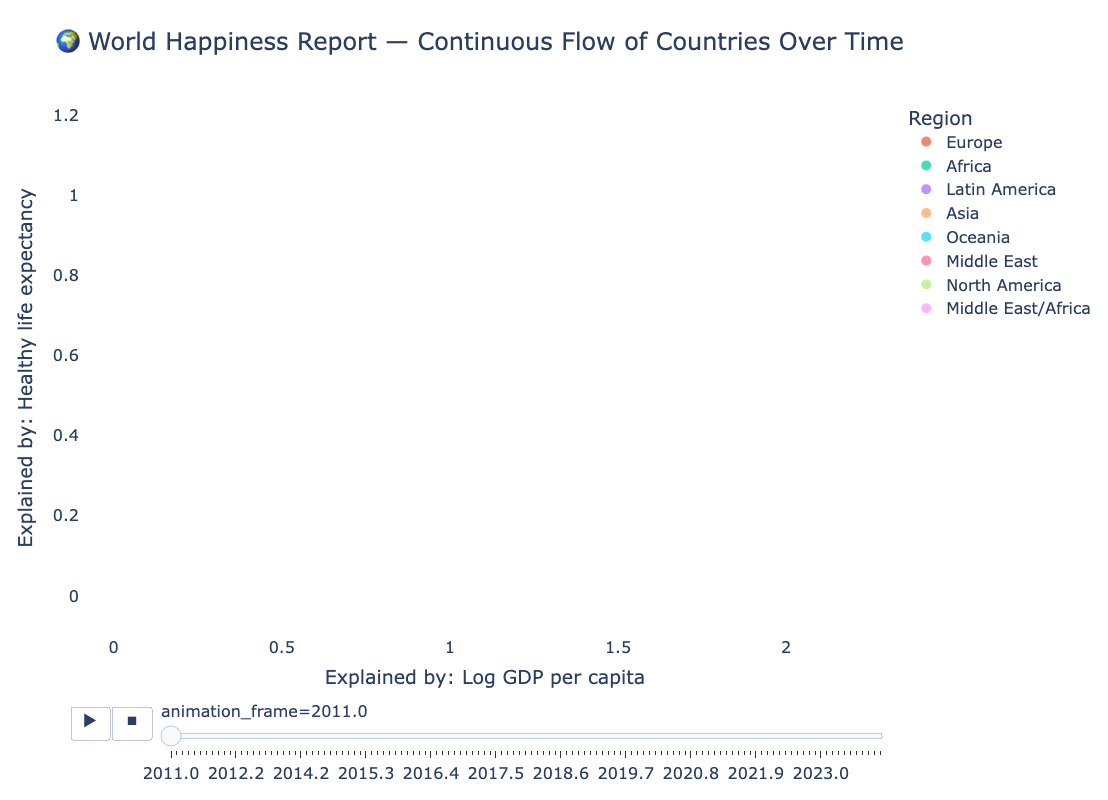

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
 
# Load dataset
df = pd.read_excel("WHR25_Data_Figure_2.1.xlsx")
df.columns = df.columns.str.strip()

df["Region"] = df["Country name"].map(region_map)
 
years = sorted(df["Year"].unique())
all_frames = []

for i in range(len(years) - 1):
    year_start, year_end = years[i], years[i+1]
    df_start = df[df["Year"] == year_start].set_index("Country name")
    df_end = df[df["Year"] == year_end].set_index("Country name")
    
    # Align by country (drop if missing in either year)
    common_countries = df_start.index.intersection(df_end.index)
    df_start, df_end = df_start.loc[common_countries], df_end.loc[common_countries]
    
    # Generate smooth intermediate frames (10 steps per year)
    steps = 10
    for j in range(steps):
        alpha = j / steps
        df_interp = df_start.copy()
        for col in ["Ladder score", "Explained by: Log GDP per capita", "Explained by: Healthy life expectancy"]:
            df_interp[col] = (1-alpha)*df_start[col] + alpha*df_end[col]
        df_interp["Year"] = year_start + alpha*(year_end - year_start)
        all_frames.append(df_interp.reset_index())

# Add the last year
all_frames.append(df[df["Year"] == years[-1]])

# Concatenate all interpolated frames
df_smooth = pd.concat(all_frames, ignore_index=True)

# -----------------------------
# Plotly Animated Scatter
# -----------------------------
fig = px.scatter(
    df_smooth,
    x="Explained by: Log GDP per capita",
    y="Explained by: Healthy life expectancy",
    size="Ladder score",
    color="Region",
    hover_name="Country name",
    animation_frame=df_smooth["Year"].round(1).astype(str),  # smooth fractional years
    animation_group="Country name",
    size_max=50,
    range_x=[df["Explained by: Log GDP per capita"].min()-0.1, df["Explained by: Log GDP per capita"].max()+0.1],
    range_y=[df["Explained by: Healthy life expectancy"].min()-0.1, df["Explained by: Healthy life expectancy"].max()+0.1],
    title="🌍 World Happiness Report — Continuous Flow of Countries Over Time"
)

# Make animation smooth & slow
fig.update_layout(
    height=800, width=1500,
    font=dict(size=16),
    title_font=dict(size=24),
    plot_bgcolor="white"
)
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 300  # slower per frame
fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 300  # smooth ease

fig.show()

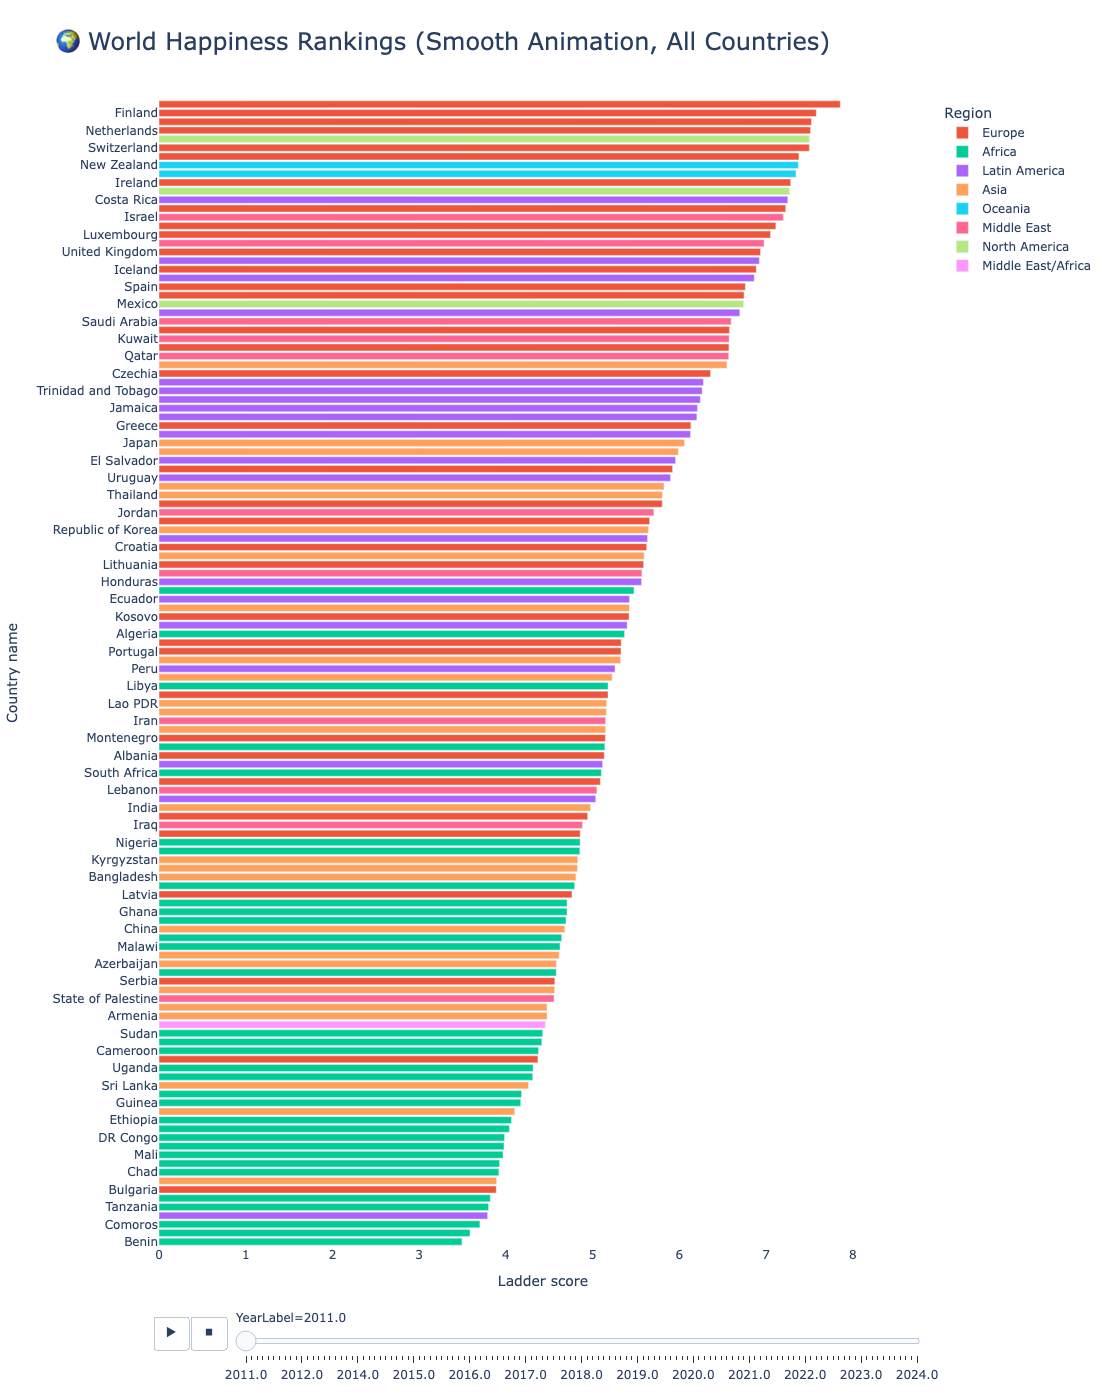

In [4]:
rankings = df[["Year", "Country name", "Rank", "Ladder score", "Region"]].sort_values(["Year", "Rank"])

years = sorted(df["Year"].unique())
all_frames = []

for i in range(len(years) - 1):
    year_start, year_end = years[i], years[i+1]
    df_start = df[df["Year"] == year_start].set_index("Country name")
    df_end = df[df["Year"] == year_end].set_index("Country name")
    
    # Align by country (drop if missing in either year)
    common_countries = df_start.index.intersection(df_end.index)
    df_start, df_end = df_start.loc[common_countries], df_end.loc[common_countries]
    
    # Generate smooth intermediate frames (10 steps per year)
    steps = 10
    for j in range(steps):
        alpha = j / steps
        df_interp = df_start.copy()
        for col in ["Ladder score", "Rank"]:
            df_interp[col] = (1-alpha)*df_start[col] + alpha*df_end[col]
        df_interp["Year"] = year_start + alpha*(year_end - year_start)
        all_frames.append(df_interp.reset_index())

# Add final year
all_frames.append(df[df["Year"] == years[-1]])

# Concatenate interpolated frames
df_smooth = pd.concat(all_frames, ignore_index=True)

# Round year labels for animation
df_smooth["YearLabel"] = df_smooth["Year"].round(1).astype(str)

# -----------------------------
# Plotly Bar Chart Race
# -----------------------------
fig = px.bar(
    df_smooth,
    x="Ladder score",
    y="Country name",
    orientation="h",
    color="Region",
    animation_frame="YearLabel",
    animation_group="Country name",
    range_x=[0, df["Ladder score"].max() + 1],
    title="🌍 World Happiness Rankings (Smooth Animation, All Countries)",
    height=1400, width=1600
)

# Make Rank 1 appear at top
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    font=dict(size=12),
    title_font=dict(size=24),
    plot_bgcolor='white'
)

# Slow down animation
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 3000
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 3000

fig.show()

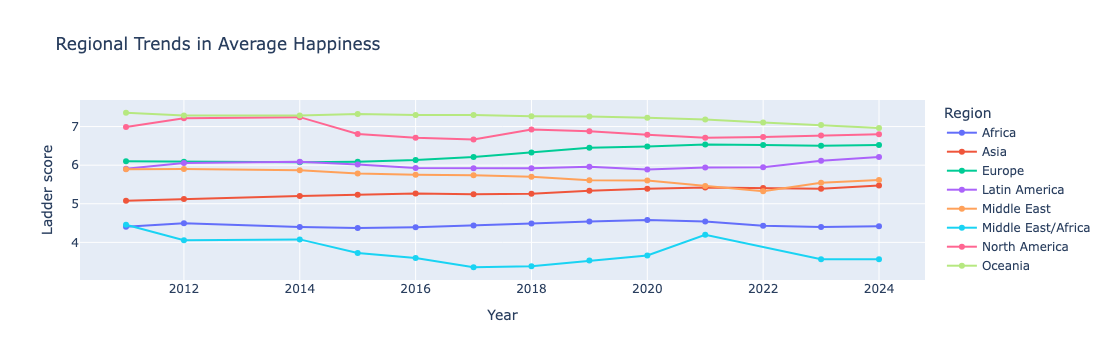

In [5]:
region_trends = df.groupby(["Year","Region"])["Ladder score"].mean().reset_index()

fig = px.line(
    region_trends,
    x="Year", y="Ladder score",
    color="Region",
    markers=True,
    title="Regional Trends in Average Happiness"
)
fig.show()


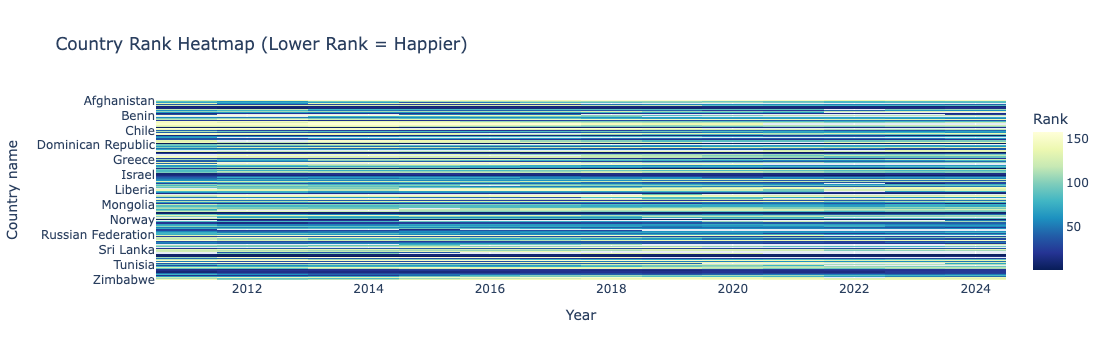

In [6]:
heatmap_data = df.pivot(index="Country name", columns="Year", values="Rank")

fig = px.imshow(
    heatmap_data,
    aspect="auto",
    color_continuous_scale="YlGnBu_r",
    title="Country Rank Heatmap (Lower Rank = Happier)",
    labels=dict(color="Rank")
)
fig.update_yaxes(autorange="reversed")  # so Rank 1 is at the top
fig.show()


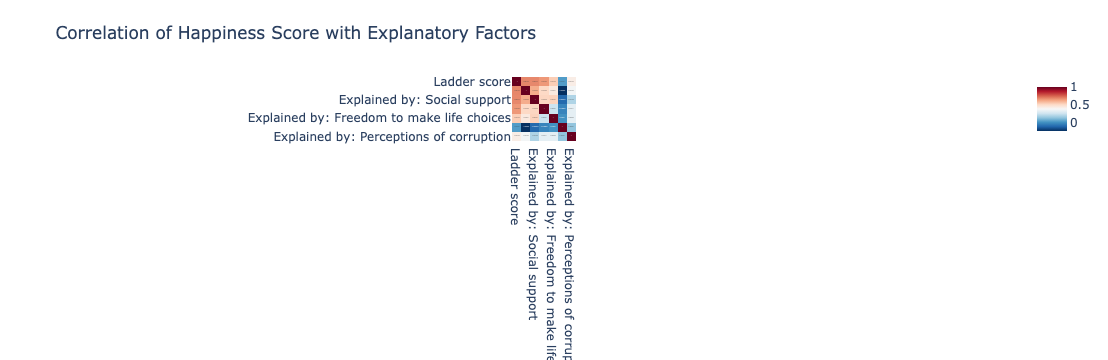

In [7]:
corr = df[[
    "Ladder score",
    "Explained by: Log GDP per capita",
    "Explained by: Social support",
    "Explained by: Healthy life expectancy",
    "Explained by: Freedom to make life choices",
    "Explained by: Generosity",
    "Explained by: Perceptions of corruption"
]].corr()

fig = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    title="Correlation of Happiness Score with Explanatory Factors"
)
fig.show()


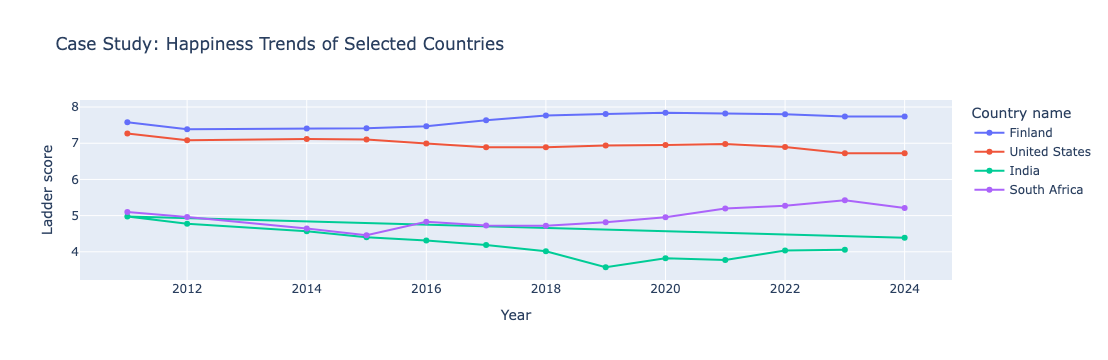

In [8]:
case_countries = ["Finland", "United States", "India", "South Africa"]
case_df = df[df["Country name"].isin(case_countries)]

fig = px.line(
    case_df,
    x="Year", y="Ladder score",
    color="Country name",
    markers=True,
    title="Case Study: Happiness Trends of Selected Countries"
)
fig.show()
